# Feature engineering
------------------------------

This example shows how to use automated feature generation to improve your model's performance.

The data used is a variation on the Australian weather dataset from [https://www.kaggle.com/jsphyg/weather-dataset-rattle-package](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package). The goal of this dataset is to predict whether or not it will rain tomorrow training a binay classifier on target `RainTomorrow`.

## Load the data

In [1]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

In [2]:
# Load data
X = pd.read_csv('./datasets/weatherAUS.csv')

# Let's have a look at a subset of the data
X.sample(frac=1).iloc[:5, :8]

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed
120852,Perth,17.4,20.7,2.2,2.0,2.0,SSE,28.0
119055,Perth,13.7,27.5,0.0,4.4,7.8,SW,20.0
31067,Sydney,10.7,17.2,0.0,5.0,1.2,NW,61.0
133547,AliceSprings,5.8,15.7,2.8,0.2,7.3,ESE,46.0
36672,WaggaWagga,3.9,13.6,0.4,1.4,9.5,WSW,39.0


## Run the pipeline

In [3]:
# Initiate ATOM and apply data cleaning
atom = ATOMClassifier(X, n_rows=1e4, test_size=0.2, verbose=0, random_state=1)
atom.clean()
atom.impute(strat_num='knn', strat_cat='remove', min_frac_rows=0.8)
atom.encode(max_onehot=10, frac_to_other=0.04)

# Let's see how a LightGBM model performs without adding additional features
atom.run('LGB', metric='auc')
atom.scoring()

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Results ===================== >>
LightGBM --> roc_auc: 0.872


## Deep Feature Synthesis

In [4]:
atom.verbose = 2  # Increase verbosity to see the output

# Create 50 new features using DFS
atom.branch = 'dfs'
atom.feature_generation(strategy='dfs', n_features=50, operators=['add', 'sub', 'log', 'sqrt'])

New branch 'dfs' successfully created!
Fitting FeatureGenerator...
Creating new features...
 --> 50 new features were added to the dataset.


divide by zero encountered in log


In [5]:
# The warnings warn us that some operators created missing values!
# We can see the columns with missing values using the missing attribute
atom.missing

['', '?', 'NA', 'nan', 'NaN', 'None', 'inf']

In [6]:
# And turn off warnings in the future
atom.warnings = False

In [7]:
# We can use the impute method again
atom.impute(strat_num='knn', strat_cat='remove', min_frac_rows=0.8)

Fitting Imputer...
Imputing missing values...


In [8]:
# 50 new features may be to much...
# Let's check for multicollinearity and use RFECV to reduce the number even further
atom.feature_selection(strategy='RFECV', solver='lgb', n_features=30, scoring='auc', max_correlation=0.98)

Fitting FeatureSelector...
Performing feature selection ...
 --> Feature Location was removed due to low variance. Value 0.20781403164822854 repeated in 100% of the rows.
 --> Feature Cloud3pm + Humidity3pm was removed due to collinearity with another feature.
 --> Feature Cloud3pm + RainToday_No was removed due to collinearity with another feature.
 --> Feature Cloud3pm - Location was removed due to collinearity with another feature.
 --> Feature Cloud3pm - RainToday_No was removed due to collinearity with another feature.
 --> Feature Evaporation + WindGustDir was removed due to collinearity with another feature.
 --> Feature Evaporation - WindDir3pm was removed due to collinearity with another feature.
 --> Feature Humidity9am - WindDir3pm was removed due to collinearity with another feature.
 --> Feature Location + MinTemp was removed due to collinearity with another feature.
 --> Feature Location + RainToday_No was removed due to collinearity with another feature.
 --> Feature Loc

In [9]:
# The collinear attribute shows what features were removed due to multicollinearity
atom.collinear

,drop_feature,correlated_feature,correlation_value
0,Cloud3pm + Humidity3pm,Humidity3pm,0.99578
1,Cloud3pm + RainToday_No,Cloud3pm,0.98124
2,Cloud3pm - Location,"Cloud3pm, Cloud3pm + RainToday_No","1.0, 0.98124"
3,Cloud3pm - RainToday_No,"Cloud3pm, Cloud3pm - Location","0.98405, 0.98405"
4,Evaporation + WindGustDir,Evaporation,0.9999
5,Evaporation - WindDir3pm,"Evaporation, Evaporation + WindGustDir","0.9999, 0.99969"
6,Humidity9am - WindDir3pm,Humidity9am,1.0
7,Location + MinTemp,MinTemp,1.0
8,Location + RainToday_No,"RainToday_Yes, RainToday_No","-0.98404, 1.0"
9,Location + WindDir3pm,WindDir3pm,1.0


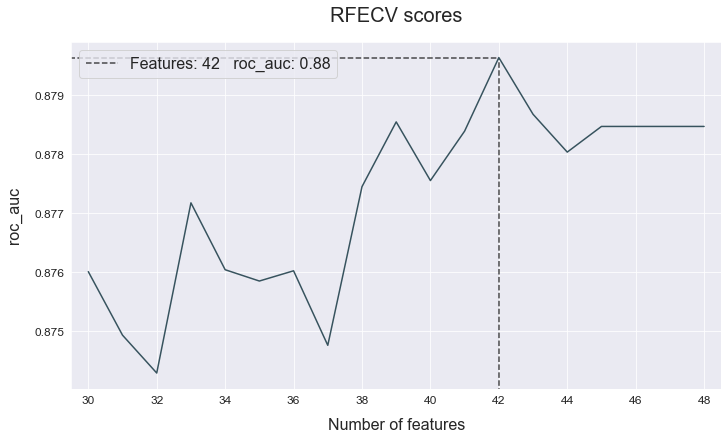

In [10]:
# After applying RFECV, we can plot the score per number of features
atom.plot_rfecv()

In [11]:
# Let's see how the model performs now
atom.run('LGB_DFS')


Training ===================================== >>
Models: LGB_DFS
Metric: roc_auc


Results for LightGBM:         
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9947
Test evaluation --> roc_auc: 0.8764
Time elapsed: 0.459s
-------------------------------------------------
Total time: 0.459s


Final results ========================= >>
Duration: 0.460s
------------------------------------------
LightGBM --> roc_auc: 0.876


## Genetic Feature Generation

In [12]:
# Create another branch for the genetic features
atom.branch = 'gfg_from_main'

# Create new features using Genetic Programming
atom.feature_generation(strategy='GFG', n_features=20, generations=10, population=2000)

New branch 'gfg' successfully created!
Fitting FeatureGenerator...
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     3.17         0.127544        3         0.504266              N/A     10.33s
   1     3.10          0.33852        5         0.536639              N/A      9.01s
   2     3.50         0.443648        9         0.541754              N/A      7.67s
   3     4.48         0.476799        7         0.544984              N/A      6.47s
   4     6.25          0.51219       13         0.546135              N/A      5.57s
   5     7.45         0.508814        9         0.550855              N/A      4.40s
   6     7.66         0.501224       11          0.55326              N/A      3.41s
   7     8.05         0.498132       11         0.553417              N/A      2.26s
   8    

In [13]:
# We can see the feature's fitness and description through the genetic_features attribute
atom.genetic_features

,name,description,fitness
0,Feature 24,"mul(mul(sub(sub(sub(Humidity3pm, Sunshine), Su...",0.542417
1,Feature 25,"mul(sub(sub(sub(Humidity3pm, Sunshine), Sunshi...",0.542417
2,Feature 26,"mul(Humidity3pm, mul(sub(sub(sub(Humidity3pm, ...",0.542417
3,Feature 27,"mul(sub(sub(Humidity3pm, Sunshine), Sunshine),...",0.542260
4,Feature 28,"mul(mul(sub(Humidity3pm, Sunshine), WindGustSp...",0.542260


In [14]:
# And fit the model again
atom.run('LGB_GFG', metric='auc')


Training ===================================== >>
Models: LGB_GFG
Metric: roc_auc


Results for LightGBM:         
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9894
Test evaluation --> roc_auc: 0.8771
Time elapsed: 0.313s
-------------------------------------------------
Total time: 0.313s


Final results ========================= >>
Duration: 0.314s
------------------------------------------
LightGBM --> roc_auc: 0.877


## Analyze results

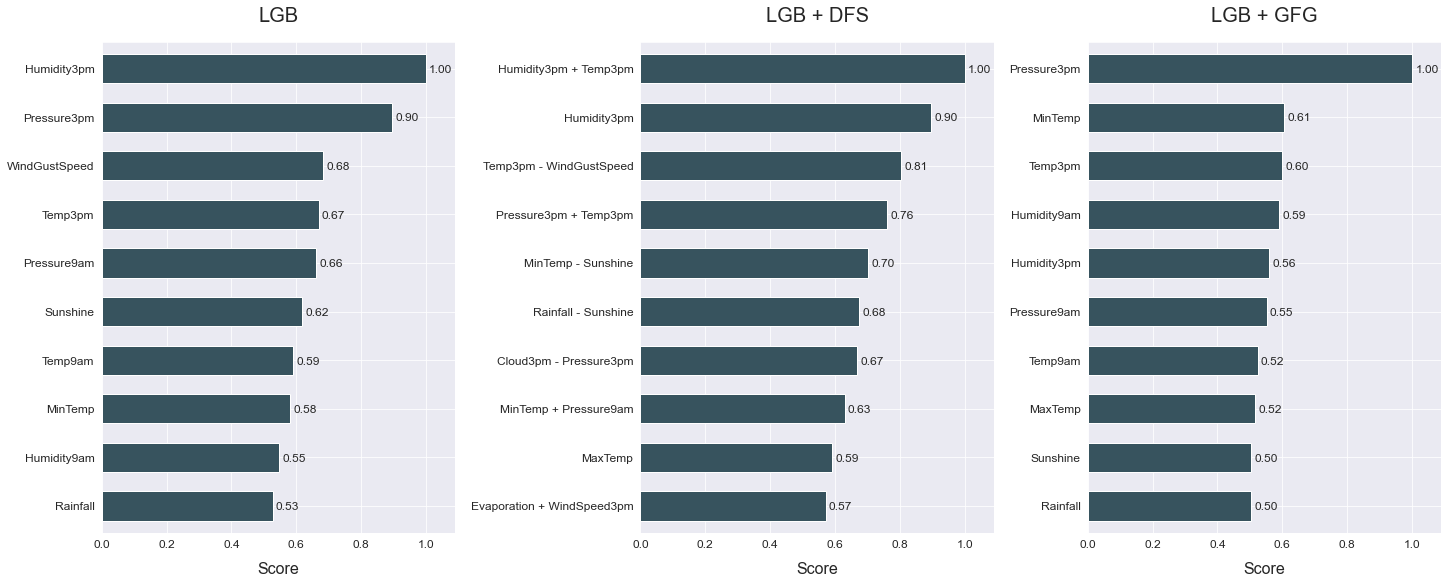

In [15]:
with atom.canvas(1, 3, figsize=(20, 8)):
    atom.lgb.plot_feature_importance(show=10, title="LGB")
    atom.lgb_dfs.plot_feature_importance(show=10, title="LGB + DFS")
    atom.lgb_gfg.plot_feature_importance(show=10, title="LGB + GFG")

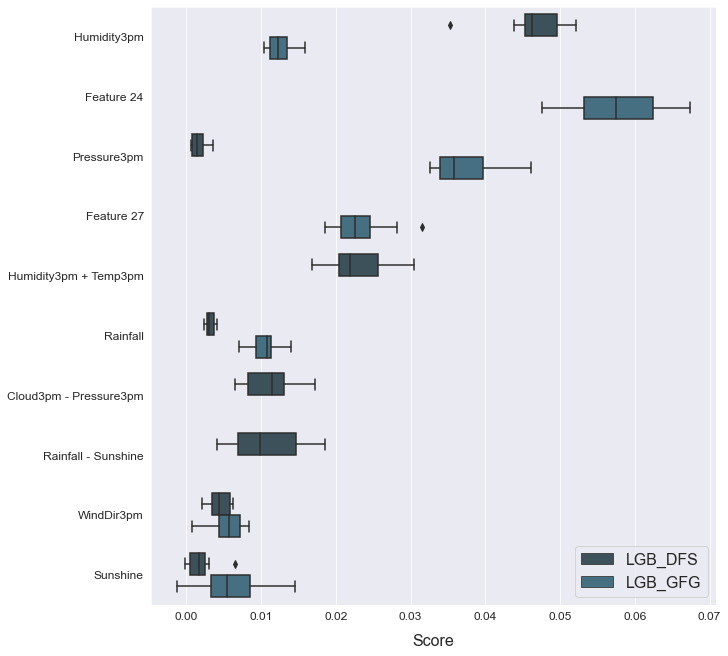

In [16]:
# We can check the feature importance with other plots as well
atom.plot_permutation_importance(models=["LGB_DFS", "LGB_GFG"], show=10)